# Linear Transformation 
We will start with the alignement of the same models for different seeds. 
- First we do not restrict the matrix.
- Second we restrict the matrix to be a rotation matrix.
- Thrid use affine transformation 
- Last but not least we are using different norms and regularization techniques to improve the results



Steps: 
- Load the same model but with different seed
- Sample different images and get latent representation 
- Create Datamatrix X and X'
- Solve the simple optimization problem


In [157]:
# Import relevant libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from sklearn.decomposition import PCA


In [158]:
# Configuration

config = {
    'path1': "/Users/mariotuci/Desktop/Google-Drive/Master/SoSe-24/Project Studies/Project/Code/latent-communication/VAE/models/MNIST_VAE_1_10.pth",
    'modelname1': 'VAE1',
    'path2': "/Users/mariotuci/Desktop/Google-Drive/Master/SoSe-24/Project Studies/Project/Code/latent-communication/VAE/models/MNIST_VAE_2_10.pth",
    'modelname2': 'VAE2',

}

# Optimization Problem in the Linear Case 
Let $x^i,y^i \in \mathbb{R^n}$ for $i = 1,...,m$ and $A \in \mathbb{R}^{n \times n}$ we are looking for the optimal A, which solves the following optimization problem 
$$ min_A \sum_{i = 1}^n ||Ax^i - y^i||^2 $$
where we are using the euclidian norm when not otherwise stated.



## Load Model and Transformed Data for VAE

In [159]:
# get working directory
import os
# Change directory
os.chdir('/Users/mariotuci/Desktop/Google-Drive/Master/SoSe-24/Project Studies/Project/Code/latent-communication')

# Import Data 
from helper.DataLoaderMNIST import DataLoader_MNIST

# Transdormations
transformations = [transforms.ToTensor(), 
                                # Normalize between -1 and 1
                                transforms.Normalize((0.5,), (0.5,)),
                                # Flatten the Image to a vector
                                transforms.Lambda(lambda x: x.view(-1) )
                                ]
# Load the data
data_loader = DataLoader_MNIST(128, transformations)

from VAE.model_def import VAE
DEVICE = torch.device('mps')

# Initialize the models
model = VAE(in_dim=784, dims=[256, 128, 64, 32], distribution_dim=16).to(DEVICE)

# Load pretrained weights for model1
model.load_state_dict(torch.load(config['path1']))

# Initialize the model 2
model2 = VAE(in_dim=784, dims=[256, 128, 64, 32], distribution_dim=16).to(DEVICE)
# Load pretrained weights for model2
model2.load_state_dict(torch.load(config['path2']))




<All keys matched successfully>

## Sampling 
We sample images from the train set and encode those for each model 

In [176]:
# Simple Sampler which takes random points from the train set

def sampler(m,model1, model2): 
    images, _ = next(iter(data_loader.train_loader))
    all_images = []
    all_labels = []
    for images, labels in data_loader.train_loader:
        all_images.append(images)
        all_labels.append(labels)
    # Concatenate all the batches to form a single tensor for images and labels
    all_images = torch.cat(all_images, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
     # Sample indices from the train set
    indices = np.random.choice(all_images.shape[0], m, replace=False)

    all_images_sample = all_images[indices]
    all_labels_sample = all_labels[indices]
    

    z1 = model1.getLatenSpace(all_images_sample.to(DEVICE))
    z2 = model2.getLatenSpace(all_images_sample.to(DEVICE))

    # Detach from GPU
    z1 = z1.detach().cpu().numpy()
    z2 = z2.detach().cpu().numpy()  

    return z1, z2, all_images_sample, all_labels_sample

z1, z2, images, labels = sampler(100, model, model2)


print(z1.shape[1])
print(z2.shape)
 

32
(100, 32)


# Calulate optimal matrix 
To ensure invertibility we using as regularization the Matrix in the Frobeniusnorm with lamda as regularization parameter

In [177]:
def optimalMatrix(z1,z2,lamda = 0.001):
    # Get the dimensions of the latent space
    d = z1.shape[1]

    # Initalize the matrices
    M = np.zeros((d, d))
    L = np.zeros((d, d))

    # Compute the matrices
    for i in range(d):
        M = M + np.outer(z1[i], z2[i])
        L = L + np.outer(z1[i], z2[i])

    # COmpute the optimal regularized matrix
    A = L @ np.linalg.inv(M + lamda * np.eye(d))

    return A

A = optimalMatrix(z1,z2)

print(A.shape)






(32, 32)


# Distance regarding the sample size 

In [181]:
def transformedDistances(z1, z2, A):
    # Compute the transformed distances
    distances = np.zeros(z1.shape[0])
    for i in range(z1.shape[0]):
        distances[i] = np.linalg.norm(A @ z1[i] - z2[i])

    return distances


distances = transformedDistances(z1, z2, A)
print(distances.shape)

print(distances)

(100,)
[14.54217411 15.0955607  16.51850568 16.32794972 13.20486296 15.61886369
 16.6256526  15.21808952 15.16223141 16.94807447 16.1304701  14.91973233
 16.37560107 14.12434709 15.35696416 12.27807105 15.54815069 14.90267703
 13.59741382 15.00078532 15.10837369 15.50677222 16.011405   16.35308997
 14.40488457 15.07407757 15.44604502 14.77228867 15.69187675 17.15462337
 16.25520234 13.95542999 16.24058361 17.49211694 14.16030051 13.90460876
 16.13794307 15.08243214 16.8462063  13.39028022 15.36222735 17.47253233
 15.23133204 16.87122167 13.87732666 14.74913446 16.8598548  18.50391576
 17.92528127 16.00537778 14.15028702 15.79563394 15.76249652 16.13452342
 16.28938182 16.92941227 43.92052284 16.15706289 16.01026122 16.11272657
 17.84818406 17.88705892 18.19915084 13.89898129 14.28612414 14.13873643
 17.15905449 12.89960575 16.07030142 13.6485604  18.21200762 15.66266097
 13.88139796 14.22129955 12.51349763 15.11261964 14.18904231 15.82293976
 18.32664298 14.03155065 15.90266551 15.6329

# Alignement of Transformed Latent Vectors 

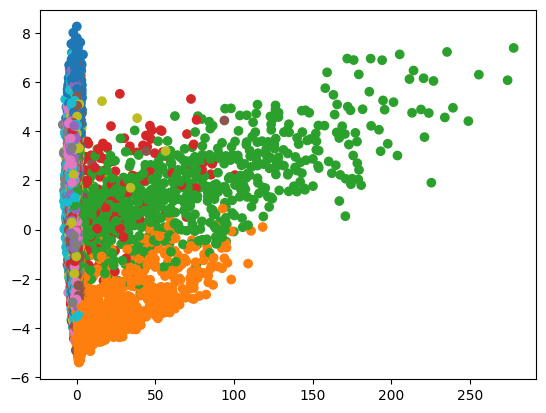

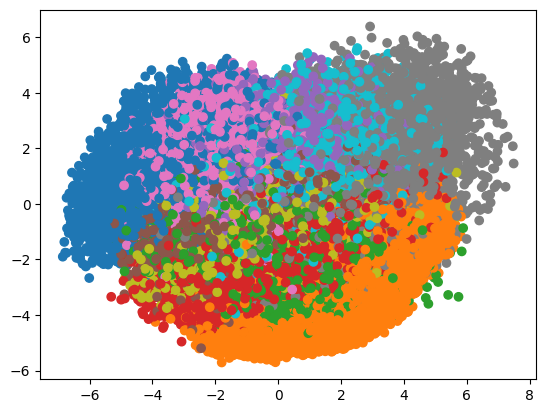

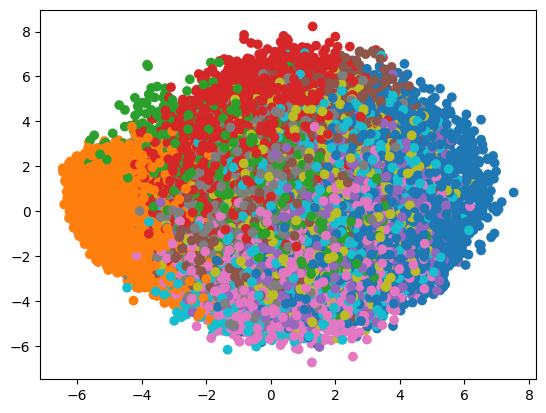

array([[5.16197968, 5.14962244, 0.        , ..., 0.58861107, 3.35547137,
        3.9331646 ],
       [3.89358592, 2.22707009, 0.        , ..., 1.00377142, 3.88295341,
        3.25739598],
       [4.0554328 , 4.71605587, 0.        , ..., 0.47127053, 3.08402395,
        3.58791256],
       ...,
       [5.43244886, 2.93583536, 0.        , ..., 1.75394177, 3.51046157,
        4.80794525],
       [5.15239048, 3.4858911 , 0.        , ..., 1.05392075, 5.38161278,
        4.39023304],
       [3.6786263 , 2.45311141, 0.        , ..., 0.79928207, 3.41646528,
        3.50927734]])

In [182]:
def plotLatentTransformed(model, A):
    images, _ = next(iter(data_loader.train_loader))
    latent_spaces = []
    all_labels = []
    for images, labels in data_loader.train_loader:
        images = images.to(DEVICE)
        images = images.view(images.size(0), -1)
        latent_space = model.getLatenSpace(images)
        latent_space = latent_space.cpu().detach().numpy()
        latent_spaces.append(latent_space)
        all_labels.append(labels.numpy())

    # Concatenate latent space representations from all batches
    latent_space = np.concatenate(latent_spaces, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    pca = PCA(n_components=3)
    # Transform the latent space
    latent_space_transformed = np.dot(latent_space, A.T)
    # Plot latent space via PCA
    latent_space_pca = pca.fit_transform(latent_space_transformed)

    # Plot the latent space
    plot = plt.scatter(latent_space_pca[:, 0], latent_space_pca[:, 1], c=all_labels, cmap='tab10', label=all_labels)
    plt.show(plot)

    return latent_space_transformed

I = np.eye(32)

plotLatentTransformed(model, A)
plotLatentTransformed(model2, I)
plotLatentTransformed(model, I)


